# Gradient tape

* https://www.tensorflow.org/guide/autodiff
* https://www.pyimagesearch.com/2020/03/23/using-tensorflow-and-gradienttape-to-train-a-keras-model/
* https://towardsdatascience.com/custom-loss-function-in-tensorflow-2-0-d8fa35405e4e
* https://stackoverflow.com/questions/56657993/how-to-create-a-keras-layer-with-a-custom-gradient-in-tf2-0/56658149#56658149

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

**GradientTape** catches what's happening inside its `with` structure with TF variables, and calculates gradients. Can do matrix form, anything. The only limitation, the result can be called only once (unless you make the tape 'persistent' apparently), as by default the tape is destroyed during gradient calculation. But you can calculate many gradients at once.

Gradients have the same exact shape as original variables.

In [2]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape:
    y = x**2

tape.gradient(y, x).numpy()

2.0

In [3]:
x = tf.Variable([1.0, 2.0, 3.0])

with tf.GradientTape() as tape:
    y = x**2
    z = tf.math.reduce_mean(y)

print(tape.gradient(z, x).numpy())

[0.6666667 1.3333334 2.       ]


In [4]:
x = tf.Variable([1.0, 2.0, 3.0])

with tf.GradientTape() as tape:
    y = x**2
    z = tf.math.reduce_mean(y)

gradients = tape.gradient(z, [y, x])
for g in gradients:
    print(g.numpy())

[0.33333334 0.33333334 0.33333334]
[0.6666667 1.3333334 2.       ]


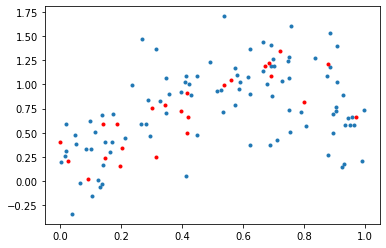

In [5]:
# Cook some simplistic data:
np.random.seed(1)
n_points = 120
xdata = np.random.uniform(size=n_points)
ydata = np.sin(xdata*0.8*np.pi) + np.random.normal(size=xdata.shape)/3

ind = list(range(np.round(n_points*0.2).astype(int)))
xtest = xdata[ind]
ytest = ydata[ind]
xdata = xdata[[i for i in range(n_points) if i not in ind ]]
ydata = ydata[[i for i in range(n_points) if i not in ind ]]

plt.plot(xdata, ydata, '.');
plt.plot(xtest, ytest, 'r.');

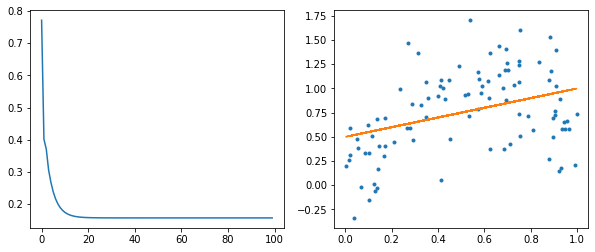

In [6]:
# Manual linear regression

rate = 0.1
a = tf.Variable([1.0], name='a')
b = tf.Variable([1.0], name='b')
x = tf.Variable(xdata, dtype=tf.float32)
target = tf.Variable(ydata, dtype=tf.float32)

memory = np.zeros(100)
for i in range(100):
    with tf.GradientTape() as tape:
        y = a * x + b
        loss = tf.math.reduce_mean((y-target)**2)

    gradients = tape.gradient(loss, [a, b])
    a = tf.Variable(a - rate*gradients[0])
    b = tf.Variable(a - rate*gradients[1])
    memory[i]= loss.numpy()
    
plt.figure(figsize=(10,4))
plt.subplot(121);
plt.plot(memory);
plt.subplot(122);
plt.plot(xdata, ydata, '.');
plt.plot(xdata, a.numpy()*xdata + b.numpy());

Variable <tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float64, numpy=array([[-0.99939667]])>
 Gradient: [[-1.61353199]]
Variable <tf.Variable 'dense/bias:0' shape=(1,) dtype=float64, numpy=array([0.])>
 Gradient: [-2.5379697]
Variable <tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float64, numpy=array([[0.32626905]])>
 Gradient: [[-0.03388833]]
Variable <tf.Variable 'dense/bias:0' shape=(1,) dtype=float64, numpy=array([0.58800935])>
 Gradient: [0.01902708]


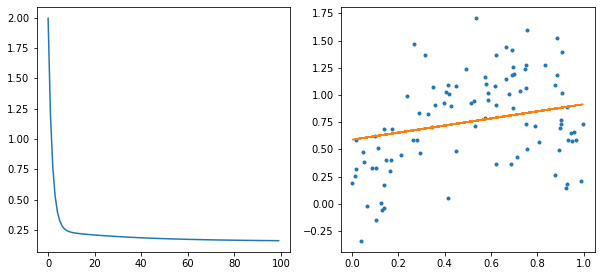

In [7]:
# Proper, TF way of applying gradients

#xtemp = np.array([0,1,2])
#ytemp = np.array([10,11,12])
xtemp = xdata
ytemp = ydata
x =      tf.constant(xtemp[:,None], dtype=tf.float64) # Make it mindim=2 kind of vector
ytrain = tf.constant(ytemp, dtype=tf.float64)
tf.keras.backend.set_floatx('float64') # Just to suppress warnings about float32 <-> float64 transitions

layer = tf.keras.layers.Dense(1, activation='linear')
#optimizer = tf.keras.optimizers.Adam(learning_rate = 1) # Adam doesn't work that well here for some reason
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)

n_steps = 100
memory = np.zeros(n_steps)
for i in range(n_steps):
    with tf.GradientTape() as tape:
        # tape.watch(layer.variables) # Not sure if this one is needed.
        y = layer(x)
        loss = tf.math.reduce_mean((tf.squeeze(y)-ytrain)**2)
        # Without this Squeeze above, y is a column, and ytrain is a row, and a difference gives a matrix,
        # not a vector. Which breaks everything obv.

    grad = tape.gradient(loss, layer.trainable_variables)
    
    if (i==0) or (i==n_steps-1):
        for v,g in zip(layer.trainable_variables, grad):
            print(f"Variable {v}\n Gradient: {g}")
    
    optimizer.apply_gradients(zip(grad, layer.trainable_variables))
    
    memory[i]= loss.numpy()
    
plt.figure(figsize=(10, 4.5))
plt.subplot(121);
plt.plot(memory);
plt.subplot(122);
plt.plot(xtemp, ytemp, '.');
plt.plot(xtemp, y, '-');

Variable <tf.Variable 'dense_21/kernel:0' shape=(3, 1) dtype=float64, numpy=
array([[ 1.86846739],
       [ 0.19916011],
       [-1.70059451]])>
 Gradient: [[-0.0047471 ]
 [ 0.00064364]
 [ 0.00408861]]
Variable <tf.Variable 'dense_21/bias:0' shape=(1,) dtype=float64, numpy=array([0.18462338])>
 Gradient: [0.00108813]


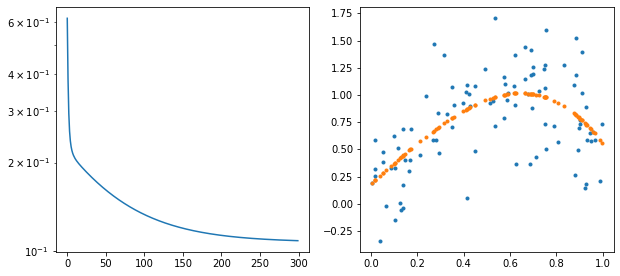

In [34]:
# Similar, but curvilinear fit

x =      tf.constant(xdata[:,None], dtype=tf.float64) # Make it mindim=2 kind of vector
ytrain = tf.constant(ydata, dtype=tf.float64)
tf.keras.backend.set_floatx('float64') # Just to suppress warnings about float32 <-> float64 transitions

layer = tf.keras.layers.Dense(1, activation='linear') # Input dim = 2 now
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.5)

n_steps = 300
memory = np.zeros(n_steps)
for i in range(n_steps):
    with tf.GradientTape() as tape:
        # tape.watch(layer.variables) # Not sure if this one is needed.
        y = layer(tf.concat((x, x**2, x**3), axis=1))
        loss = tf.math.reduce_mean((tf.squeeze(y)-ytrain)**2)

    grad = tape.gradient(loss, layer.trainable_variables)    
    optimizer.apply_gradients(zip(grad, layer.trainable_variables))    
    memory[i]= loss.numpy()
    
    if (i==n_steps-1):
        for v,g in zip(layer.trainable_variables, grad):
            print(f"Variable {v}\n Gradient: {g}")
    
plt.figure(figsize=(10, 4.5))
plt.subplot(121);
plt.plot(memory);
plt.semilogy()
plt.subplot(122);
plt.plot(xtemp, ytemp, '.');
plt.plot(xtemp, y, '.');